# Empalme con la clase anterior.
Comentario sobre la ultima tarea. Convergencia metodos upwind ($c<0$) valores del parametro CFL $\gamma$. Debe ser $-1 \le \gamma < 0$.

Se dijo que se quiere resolver el system $A\boldsymbol{x}=
\boldsymbol{b}$, donde
$A$ esta dado por la matrix que se muestra abajo y $\boldsymbol{b}$ se muestra mas abajo.

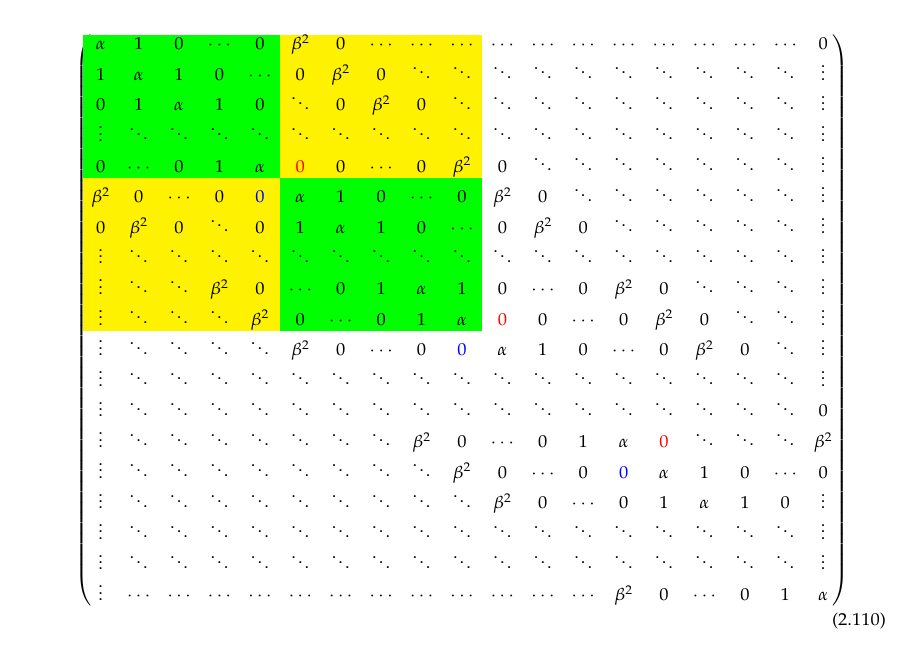

El vector $\boldsymbol{b}$ es de la forma
\begin{eqnarray}
  b_{\ell} =\Delta x^2 \rho_{\ell} - c_{\ell}
\end{eqnarray}
donde $c_{\ell}$ es la componente $\ell$ del vector $\boldsymbol{c}$ representado, en
su forma transpuesta, por la siguiente ecuaci'on


\begin{eqnarray}
  \boldsymbol{c} = (e_1 +g_1 \beta^2 \, , \, g_2 \beta^2\, ,\,  \cdots\, ,\,  g_{nx-2} \beta^2\, ,
  \, g_{nx-1} \beta^2 + f_1 \, ,  \, e_2 \, ,  \,  0 \, ,  \, \cdots \, , \, 0 \, ,  \,  
  f_2 \, ,  \, e_3 \, , \,  0 \, ,  \, \cdots \, ,  \,
  0, f_3, \cdots, \cdots,  \nonumber \\
  e_{nx-2} \, , \, 0 \, , \,  \cdots \, , \, 0 \, ,  \, f_{nx-2} \, ,  \, \cdots \, , \,
  e_{ny-1} + h_1 \beta^2  \, ,  \, h_2 \beta^2 \, ,  \, \cdots \, , \,
  h_{nx-2} \beta^2 \, , \,  h_{nx-1} \beta^2 + f_{ny-1}).
\end{eqnarray}


# Deseño de la implementación numérica

* Asumimos que $nx>3, ny>3$.
* dimensiones de e y f son $nx-1$, $ny-1$ respectivamente y $g,h$
* $N=(nx-1)(ny-1)$, numero de nodos internos. El tamanho del vector solucion $w_{\ell}$.
* La matriz $A$ es $N \times N$ o sea $(nx-1)^2(ny-1)^2$. Esto
puede ser millones. Entonces usamos un metodo iterativo para resolver el problema. Escogemos el Guass-Seidel.

## Disenho de la matriz A
* La diagonal principal $A[i,i]=\alpha$, $i=0,1, \cdots, N-1$
* Subdiagonales encima y debajo de la princial.
$$A[i+1,i]=1, A[i , i+1]=1 , \quad i=0,1, \cdots, N-2$$. Mas adelante la modificamos para intersar 0 en los bordes derecho e izquierdo.

* Las diagonales a distancia $nx-1$, con valor $\beta^2$
$$A[i+nx-1, i]=\beta^2 , A[i, i+nx-1]=\beta^2, i=0,1, \cdots, N-nx $$

* Identificamos los valores 0 en las diagonales encima y debajo de la princial. El indice $\ell$ toma el valor alli de
$$\ell = (j-1)(nx-1) + 0 = (j-1)(nx_1)$$
En este caso $A[\ell , \ell-1]=0, A[\ell-1, \ell]=0 $

## Diesnho de la fuente (el lado derecho)
* En la capa $j=1$ ($j=0$ en $C$). se hace la asignacion $c_i=-g_i \beta^2$. Si $i=1$ se resta $e_i$, si $i=nx-1$ se resta f_i$

* Capas intermedias, entre $j=2, j=ny-1$, simplemente se resta $e_j$ para $i=1$ y f_j$ para $i=nx-1$

* Arriba, ultima capa. $j=ny-1$. Se hace la asignacion $c_\ell = -h_i \beta^2$. Si $i=1$ se resta $e_{ny-1}$ si $i=nx-1$ se resta
$f_{ny-1}$

Se usara Gauss Seidel para invertir el sistema.

## Metodos de prueba.

Existe una solucion facil de la ecuacion de Laplace que no es lineal, ni un polinomio

$$u(x,y) = \frac{y}{(1+x)^2 + y^2} $$

El probelma que queremos resolver es:

$$\nabla^2 u(x,y) = \rho(x,y) $$
En el rectangulo $[a, b] \times [c, d]$
con condiciones de frontera

$$u(a,y) = e(y) $$
$$u(b,y) = f(y) $$
$$u(x,c) = g(y) $$
$$u(x,d) = h(y) $$

Elaboracion del algoritmo


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA

def gauss_seidel(A, b, nmax, tol):
    L=np.tril(A)
    U = A - L
    n = len(b)
    x = np.zeros(n)
    k=0
    error = 10

    while (k < nmax and error > tol):
        xnew = np.dot(LA.inv(L), b - np.dot(U, x))
        error = np.linalg.norm(xnew - x)
        x = xnew
        k+=1

    if k == nmax:
        print("se alcanzo el numero maximo de iteraciones")
    print("la ultima iteracion fue k=",k)

    return x

# pretty print
def pprint(A):
    n = len(A)
    for i in range(0,n):
        line = ""
        for j in range(0,n):
            line += str(A[i,j]) + "  "
        print(line)
    print("")
    return

def solve_elliptic(dx,dy, e,f,g,h,a,b,c,d,rho,nmax,tol, verbose):
    # comentarios donde se definen todos los parametros
    # ver notas de clase

    nx = int((b-a)/dx)
    ny = int((d-c)/dy)

    # dimensiones del espacio solucion
    N=(nx-1)*(ny-1)

    # ejes x y y
    X = np.linspace(a+dx, b-dx, nx-1)
    Y = np.linspace(c+dy, d-dy, ny-1)

    # matriz y vector solucion. Inicializacion
    A = np.zeros((N,N))
    b = np.zeros(N)

    # quality control
    print("Tamanho de la matriz A ese", len(A)**2)
    print("Tamaño del vector b es", len(b))

    # variables intermedias
    beta = dx/dy
    alpha = -2.0*(1.0 + beta**2)

    # llenamos la matriz A
    for i in range(N):
        # diagonal principal
        A[i,i] = alpha

        # subdiagonales encima y debajo
        if i < N-1:
            A[i+1,i] = 1.0
            A[i,i+1] = 1.0

        # subdiagonles remotas
        if i <= N - nx:
            A[i+nx-1,i] = beta**2
            A[i,i+nx-1] = beta**2

    # modificacion de valores en subdiagonales inmediatas
    for j in range(2, ny):
        l = (j-1)*(nx-1)
        A[l-1,l] = 0.0
        A[l,l-1] = 0.0

    # vector b
    for j in range(ny-1):
        for i in range(nx-1):
            l = j*(nx-1) + i

            # asignacion inicial de densidades
            rhol = rho(X[i], Y[j])
            b[l] = dx**2*rhol


            # primera capa
            if j == 0:
                b[l] -= g(X[i])*beta**2

                # esquina inferior izquierda
                if i==0:
                    b[l] -= e(Y[j])
                # esquina inferior derecha
                if i == nx-2:
                    b[l] -= f(Y[j])
            # capas intermedias
            if j>0 and j<ny-2:
                if i==0:
                    b[l] -= e(Y[j])
                if i==nx-2:
                    b[l] -= f(Y[j])

            # ultima capa
            if j==ny-2:
                b[l] -= h(X[i])*beta**2
                # esquina superior izquierda
                if i==0:
                    b[l] -= e(Y[j])
                # esquina superior derecha
                if i==nx-2:
                    b[l] -= f(Y[j])

    # imprimir matriz, si el numero de filas no es muy grande
    if verbose:
        pprint(A)


    # Quality control: imprimir las fronteras
    if verbose:
        print("e")
        [print(" ", e(Y[j])) for j in range(ny-1)]
        print("f")
        [print(" ", f(Y[j])) for j in range(ny-1)]
        print("g")
        [print(" ", g(X[i])) for i in range(nx-1)]
        print("h")
        [print(" ", h(X[i])) for i in range(nx-1)]

    # print vector b
    if verbose:
        print("\n b")
        [print("%3.2f "%(b[l]), end='') for l in range(N)]

    # invierta el sistema usando Gauss-Seidel
    w = gauss_seidel(A, b, nmax, tol)
    return w



In [ ]:
# prueba 1
# definir condiciones de borde
def e(y):
    # return 1/(1. + y**2)
    return y/(1. + y**2)

def f(y):
    return y/(4. + y**2)

def g(x):
    return 0.0

def h(x):
    return 1./((1+x)**2 + 1)

# fuente
def rho(x,y):
    return 0

# bordes del modelo
a=0
b=1
c=0
d=1
dx=0.2
dy=0.2

nmax=100
tol=0.001

nx=int((b-a)/dx)
ny=int((d-c)/dy)

xy=solve_elliptic(dx,dy, e,f,g,h,a,b,c,d,rho,nmax,tol, 1)

# matriz solucion:
w = np.zeros([nx+1, ny+1])

# llenar la parte interna de la solucion (reshape)
for j in range(1, nx):
    for i in range(1, ny):
        l = (j-1)*(nx-1) + i-1
        w[i,j] = xy[l]

# ejex x y y
X = np.linspace(a,b,nx+1)
Y = np.linspace(c,d,ny+1)

# llenar las condiciones de frontera
for i in range(nx+1):
    w[i,0] = g(X[i])
    w[i,nx] = h(X[i])

for j in range(ny+1):
    w[0,j] = e(Y[j])
    w[nx,j] = f(Y[j])





Tamanho de la matriz A ese 256
Tamaño del vector b es 16
-4.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1.0  -4.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
0.0  1.0  -4.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
0.0  0.0  1.0  -4.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1.0  0.0  0.0  0.0  -4.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
0.0  1.0  0.0  0.0  1.0  -4.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  
0.0  0.0  1.0  0.0  0.0  1.0  -4.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  
0.0  0.0  0.0  1.0  0.0  0.0  1.0  -4.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  
0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  -4.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  
0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  -4.0  1.0  0.0  0.0  1.0  0.0  0.0  
0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  -4.0  1.0  0.0  0.0  1.0  0.0  
0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0

## Grafique la solucion analitica y numerica
$$u(x,y) = \frac{1}{(1 + x)^2 + y^2} $$





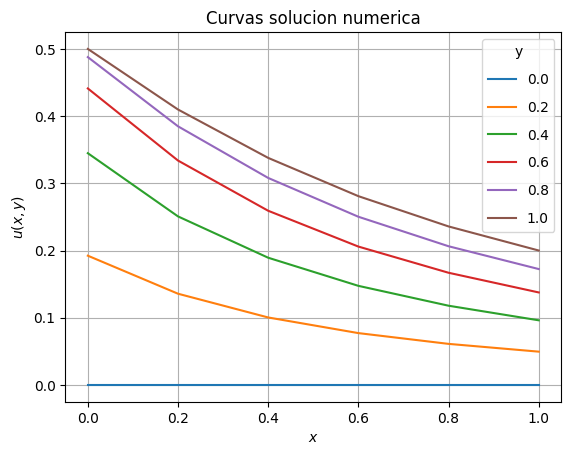

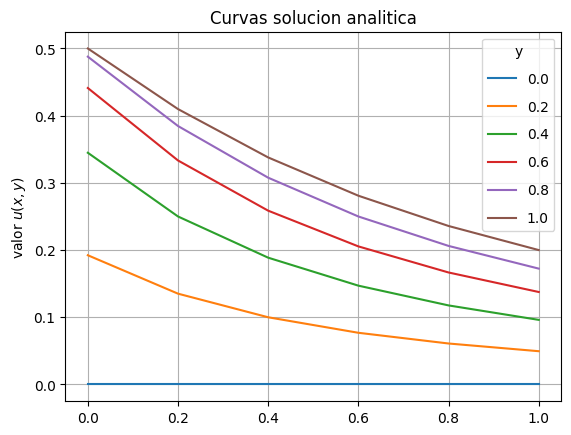

In [ ]:
# solucion analitica
def u(x,y):
    return y/ (  (1.0+x)**2 + y**2)

nx = int((b-a)/dx)
ny = int((d-c)/dy)


# graficamos las columnas de w
params={'legend.fontsize':5, 'legend.handlength':1}
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x,y)$")
plt.title(r'Curvas solucion analitica')

X = np.linspace(a,b,w.shape[0])

plt.title(r'Curvas solucion numerica')
for j in range(0, ny+1):
    plt.plot(X, w[:,j], label=str(round(j*dy,2)))
    plt.legend(labelspacing=1, title='y')

plt.grid(True)
plt.show()

plt.title(r'Curvas solucion analitica')
plt.ylabel(r'valor $u(x,y)$')

for j in range(0, ny+1):
    plt.plot(X, u(X, j*dy), label=str(round(j*dy, 1)))
    plt.legend(labelspacing=1, title='y')


plt.grid(True)
plt.show()





## Graficamos el error

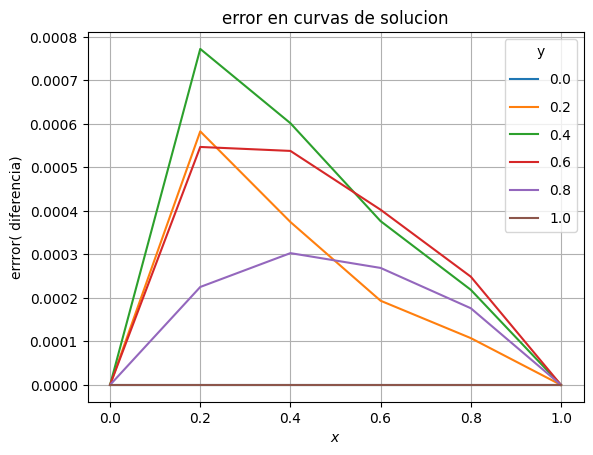

In [ ]:
# inicializamos el error
error = np.zeros([nx+1, ny+1])
Y = np.linspace(c,d,ny+1)

# llenamos el error
for j in range(0, ny+1):
    for i in range(nx+1):
        error[i,j]=w[i,j]-u(X[i], Y[j])

# graficamos el error
params={'legend.fontsize':5, 'legend.handlength':1}
plt.xlabel(r"$x$")
plt.ylabel(r"errror( diferencia)")
plt.title(r"error en curvas de solucion")

for j in range(0, ny+1):
    plt.plot(X, error[:,j], label=str(round(j*dy,2)))
    plt.legend(labelspacing=1, title='y')

plt.grid(True)
plt.show()

## Prueba 2

In [ ]:
def e(y):
    return 0

def f(y):
    return 0

def g(x):
    return x*(1.0-x)

def h(x):
    return 0

def rho(x,y):
    return 0

a=0
b=1
c=0
d=1
dx=0.05
dy=0.05

nmax=1000
tol=0.01

nx = int((b-a)/dx)
ny = int((d-c)/dy)

xy = solve_elliptic(dx,dy, e,f,g,h,a,b,c,d,rho,nmax,tol,0)

# matriz de solucion
w = np.zeros([nx+1, ny+1])

# llenar la parte interna de la solucion (reshape)
for j in range(1, nx):
    for i in range(1, ny):
        l = (j-1)*(nx-1) + i-1
        w[i,j] = xy[l]


# ejes x y y
X = np.linspace(a,b,nx+1)
Y = np.linspace(c,d,ny+1)

# condiciones de frontera
for i in range(nx+1):
    w[i,0] = g(X[i])
    w[i,nx] = h(X[i])

for j in range(ny+1):
    w[0,j] = e(Y[j])
    w[ny,j] = f(Y[j])



Tamanho de la matriz A ese 130321
Tamaño del vector b es 361
la ultima iteracion fue k= 33


## Graficar la superficie

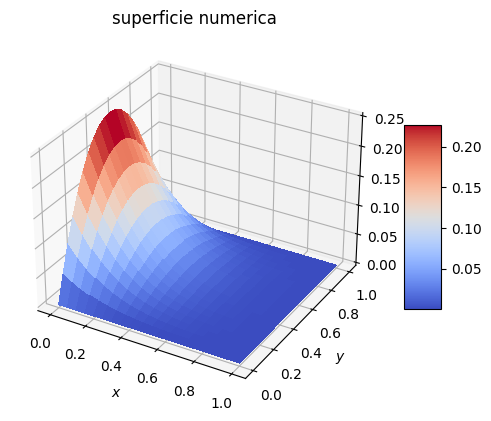

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = plt.axes(projection='3d')

# Make data.
X = np.linspace(a,b,nx+1)
Y = np.linspace(c,d,ny+1)
X, Y = np.meshgrid(X, Y)
Z = w

# Plot the surface.
surf = ax.plot_surface(X, Y, w, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
ax.set_zlabel(r"$u(x,y)$")
ax.set_title(r'superficie numerica')

# barra de colores
fig.colorbar(surf, shrink=0.5, aspect=5)

# Dimensiones superiores.
Vamos a ver la ecuacion de onda en $x,y,t$

La ecuacion es

$$\nabla^2 u(x,y,t) - \frac{1}{c^2(x,y)} \frac{\partial^2 u}{\partial^2 t}= -g(x,t) $$

Donde?
$(x,y) \in [a,b] \times [c,d]$
Condiciones de frontera e iniciales

$$u(a,y,t) = p(y,t) \quad, u(b,y,t)= q(y,t) $$
$$u(x,c,t) = r(x,t) \quad, u(x,d,t)= s(x,t) $$

Condiciones iniciales
$$u(x,y,t_0) = m(x,y) \quad , \quad u_t(x,y,t_0)= n(x,y) $$

Diferencias finitas

$$w_{ij}^k  u(x_0 + i \Delta x, y_0 + j \Delta y, t_0 + k \Delta t). $$

Hay muchos esquemas

1. Implicitos, explicitos
2. Diferencias centrales en todas partes
3. Crank-Nicholson, Leap Frog, etc

Aca hacemos diferencias centrales en todas partes


$$
\frac{w_{i+1 j}^k - 2 w_{ij}^k + w_{i-1 j}^k}{\Delta x^2}
+ \frac{w_{i j+1}^k - 2 w_{ij}^k + w_{i j-1}^k}{\Delta y^2}
-\frac{1}{c^2}
\frac{w_{i j}^{k+1} - 2 w_{ij}^k + w_{i j}^{k-1}}{\Delta t^2} = -
$$

Despejando la parte de $k+1$

$$w_{ij}^{k+1} - 2 w_{ij}^k + w_{ij}^{k-1} = \frac{c_{ij} \Delta t^2}{\Delta x^2} ( w_{i+1 j}^k - 2 w_{ij}^k + w_{i-1 j}^k) +
\frac{c_{ij} \Delta t^2}{\Delta y^2} ( w_{i j+1}^k - 2 w_{ij}^k + w_{i j-1}^k)  + c_{ij}^2 \Delta t^2$$

Despejamos $w_{ij}^{k+1}$

$$w_{ij}^{k+1} =
 2 w_{ij}^k - w_{ij}^{k-1} +   \alpha_{ij}^2 ( w_{i+1 j}^k - 2 w_{ij}^k + w_{i-1 j}^k) +
\beta_{ij}^2 ( w_{i j+1}^k - 2 w_{ij}^k + w_{i j-1}^k)  + c_{ij}^2 \Delta t^2$$

Reagrupando

$$w_{ij}^{k+1} = \alpha_{ij}^2 ( w_{i+1 j}^k + w_{i-1 j}^k) + \beta_{ij}^2 ( w_{i j+1}^k + w_{i j-1}^k) + 2(1 - \alpha^2 - \beta_{ij}^2) w_{ij}^k - w_{ij}^{k-1} + c_{ij}^2 \Delta t^2 g_{ij}^k $$


Donde
$$\alpha_{ij} = \frac{c_{ij} \Delta t}{\Delta x} \quad , \quad
\beta_{ij} = \frac{c_{ij} \Delta t}{\Delta y} $$

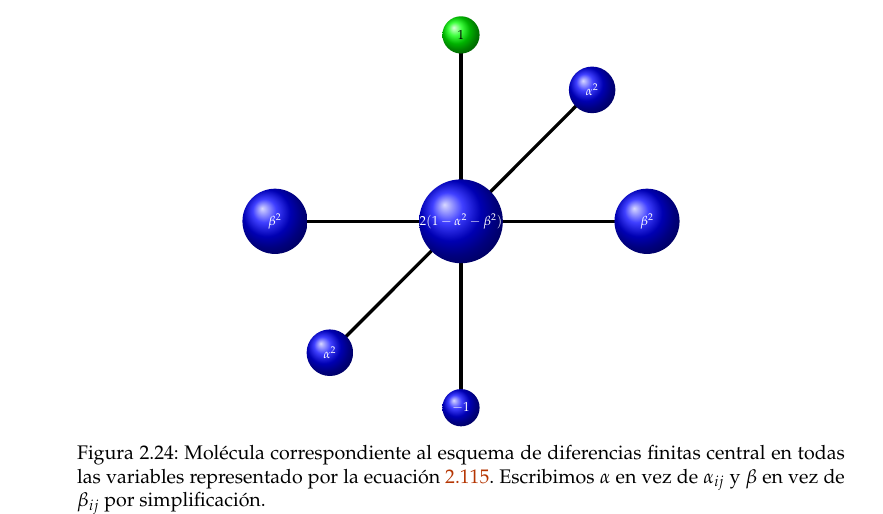

## Condiciones de bordo
$$u(a, y_0 + j \Delta y, t_0 + k \Delta t) = w_{0j}^k = p_j^k  $$
$$u(b, y_0 + j \Delta y, t_0 + k \Delta t) = w_{nxj}^k = q_j^k  $$
$$u(x_0 + i \Delta x, c, t_0 + k \Delta t) = w_{i0}^k =r_i^k $$
$$u(x_0 + i \Delta x, d, t_0 + k \Delta t) = w_{iny}^k = s_i^k$$

## condiciones iniciales
$$u(x_0 + i \Delta x, y_0 + j \Delta y, t_0) = w_{ij}^0 = m_{ij} $$
$$u_t(x_0 + i \Delta x, y_0 + j \Delta y, t_0) = w_{ij}^0 = n_{ij} $$

## Analisis de estabilidad

$$w_{ij}^k = \mathrm{e}^{\mathrm{i}(i k_x \Delta x) + j k_y \Delta y + k \omega \Delta t)} $$

El factor de ganancia es

$$G= \frac{w_{ij}^{k+1}}{w_{ij}^k} = \mathrm{e}^{\mathrm{i} \omega \Delta t} $$



Haciendo la sustitucion llegamos a (usemos velocidad constante,
no ponemos indices ni en alpha ni en beta. Ahora discutimos que pasa con velocidad variable)

$$G = 2 \alpha^2 \cos (k _x \Delta x) + 2 \beta^2 \cos (k_y \Delta y) + 2 (1 - \alpha^2 - \beta^2) - G^{-1} $$

Tenemos, redefiniendo expresiones

$$G^2 - \phi G + 1 = 0 \tag{1} $$
Donde

$$\phi = 2 \alpha^2 \cos( k_x \Delta x) + 2 \beta^2 \cos(k_y \Delta y) + 2(1 - \alpha^2 - \beta^2) $$

Como hemos hecho con los angulos dobles tenemos

$$2 \alpha^2 ( \cos k_x \Delta x) - 1) = 2 \alpha^2( 1 - 2 \sin^2 \frac{k_x \Delta x}{2} - 1) = -4 \alpha^2 \sin^2 \left ( \frac{k_x \Delta x}{2}  \right ) $$


$$2 \beta^2 ( \cos k_y \Delta y) - 1) = 2 \beta^2( 1 - 2 \sin^2 \frac{k_y \Delta y}{2} - 1) = -4 \beta^2 \sin^2 \left ( \frac{k_y \Delta y}{2}  \right ) $$


De forma que

$$\phi = -4 \alpha^2 \sin^2 \left ( \frac{k_x \Delta x}{2}  \right )  - 4 \beta^2 \sin^2 \left ( \frac{k_y \Delta y}{2} \right ) + 2 = 2 \varphi$$
donde

$$ \varphi  =
-2 \alpha^2 \sin^2 \left ( \frac{k_x \Delta x}{2}  \right )  - 2 \beta^2 \sin^2 \left ( \frac{k_y \Delta y}{2} \right ) + 1
$$




La solucion de la cuadratica (1) es:

$$G = \frac{\phi \pm \sqrt{ \phi^2 - 4}}{2}= \frac{2 \varphi \pm \sqrt{4 \varphi^2 - 4}}{2} = \varphi \pm \sqrt{\varphi^2 - 1}$$

Para que $G$ no sea mayor que 1 necesitamos

$$| \varphi | \le 1 $$
De forma que el radical es negativo. Escribimos

$$G = \varphi \pm \mathrm{i} \sqrt{1 - \varphi^2} $$

Cual es el tamano de $G$?
En este caso

$$|G| = G G^* = \varphi^2 +1 - \varphi^2 = 1 $$
De forma que el sistema converge si

$$ | \varphi | < 1$$

Esto es
$$ | \varphi |  =
| -2 \alpha^2 \sin^2 \left ( \frac{k_x \Delta x}{2}  \right )  - 2 \beta^2 \sin^2 \left ( \frac{k_y \Delta y}{2} \right ) + 1 | \le 1 $$

De aca que
$$\alpha^2 \sin^2 ( k_x \Delta x/2) +  \beta^2 \sin^2(k_y \Delta y/2) \le 1 $$

Si
$$ \alpha \le 1/\sqrt{2} \quad \text{y} \quad \beta \le 1/\sqrt{2}$$

De forma que tneemos que
$$ \alpha^2 + \beta^2 \le 1$$

y
$$ \Delta t^2 \left ( \frac{c^2}{\Delta x^2} + \frac{c^2}{\Delta y^2} \right ) \le 1   $$

De forma que

$$\Delta t \le \frac{1}{ c \sqrt{\frac{1}{\Delta x^2} + \frac{1}{\Delta y^2}}}$$

El algoritmo
Para la condicion inicial

$$\frac{w_{ij}^1 - w_{ij}^{-1}}{2 \Delta t^2} = n_{ij} $$
de aca
$$w_{ij}^{-1} = w_{ij}^1 - 2 \Delta t^2 n_{ij} \ $$

Para el primer tiempo

$$w_{ij}^1 = \alpha_{ij}^2(w_{i+1 j}^0 + w_{i-1 j}^0) + \beta_{ij}^2 ( w_{i j+1}^0 + w_{i j-1}^0) + 2(1 - \alpha_{ij}^2 - \beta_{ij}^2) w_{ij}^0 - w_{ij}^{-1} + c_{ij}^2 \Delta t^2 g_{ij}^0 $$

De aca

$$w_{ij}^1 = \frac12 [ \alpha_{ij}^2(w_{i+1 j}^0 + w_{i-1 j}^0) + \beta_{ij}^2 ( w_{i j+1}^0 + w_{i j-1}^0) + 2(1 - \alpha_{ij}^2 - \beta_{ij}^2) w_{ij}^0 + c_{ij}^2 \Delta t^2 g_{ij}^0 ]$$











